# TensorFlow Regression Example

## Creating Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf

In [3]:
# 1 Million Points
x_data = np.linspace(0.0, 10, 1000000)

In [4]:
noise = np.random.randn(len(x_data))

In [5]:
noise.shape

(1000000,)

In [6]:
# y = mx + b + noise_levels
b = 5
y_true = (0.5 * x_data) + 5 + noise

In [7]:
x_df = pd.DataFrame(data=x_data, columns=['X Data'])

In [8]:
y_df = pd.DataFrame(data=y_true, columns=['Y'])

In [9]:
my_data = pd.concat([x_df,y_df], axis=1)

In [10]:
my_data.head()

,X Data,Y
0,0.00000,6.975386
1,0.00001,4.747704
2,0.00002,5.309569
3,0.00003,5.705234
4,0.00004,4.291526


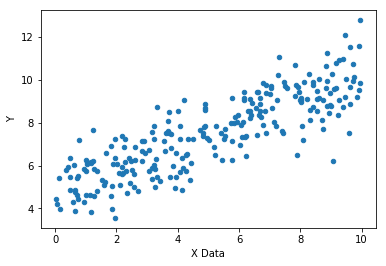

In [11]:
my_data.sample(n=250).plot(kind='scatter', x='X Data', y='Y')

# TensorFlow
## Batch Size

We will take the data in batches (1,000,000 points is a lot to pass in at once)

In [12]:
# Random 10 points to grab
batch_size = 8

** Variable **

In [13]:
# grab random number

In [14]:
np.random.randn(2)

array([-0.13983422,  0.30207613])

In [15]:
m = tf.Variable(-0.8)
b = tf.Variable(-0.6)

Instructions for updating:
Colocations handled automatically by placer.


** Placeholders **

In [16]:
xph = tf.placeholder(tf.float32, [batch_size])
yph = tf.placeholder(tf.float32, [batch_size])


** Graph **

In [17]:
y_model = m * xph + b

** Lost Function **

In [18]:
error = tf.reduce_sum(tf.square(yph - y_model))

** Optimizer **

In [19]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = optimizer.minimize(error)

** Initialize Variable **

In [20]:
init = tf.global_variables_initializer()

### Session

In [21]:
with tf.Session() as sess:
    sess.run(init)
    
    battches = 10000
    
    for i in range(battches):
        rand_ind = np.random.randint(len(x_data), size=batch_size)
        feed = {xph:x_data[rand_ind], yph:y_true[rand_ind]}
        
        sess.run(train, feed_dict=feed)
    
    model_m, model_b = sess.run([m, b])

In [22]:
model_m

0.49701983

In [23]:
model_b

5.0041947

### Results

In [24]:
y_hat = x_data * model_m + model_b

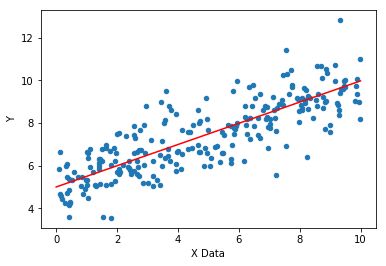

In [25]:
my_data.sample(n=250).plot(kind='scatter', x='X Data', y='Y')
plt.plot(x_data, y_hat, 'r')

## TF Estimator

In [26]:
feat_cols = [tf.feature_column.numeric_column('x', shape=[1])]

In [42]:
estimator = tf.estimator.LinearRegressor(feature_columns=feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/j8/4vht5fhd3rg9wv8rx18tt20c0000gp/T/tmpvb4zb8oc', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1539332e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Train Test Split

We haven't actually performed a train test split yet! So let's do that on our data now and perform a more realistic version of a Regression Task

In [28]:
from sklearn.model_selection import train_test_split

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_true, test_size=0.3, random_state=101)

In [37]:
print(x_train.shape)
print(y_test.shape)

(700000,)
(300000,)


### Set up Estimator Inputs

In [38]:
# Can also do .pandas_input_fn
input_func = tf.estimator.inputs.numpy_input_fn({'x':x_train}, 
                                                y_train, 
                                                batch_size=8,
                                                num_epochs=None, 
                                                shuffle=True)

In [39]:
train_input_func = tf.estimator.inputs.numpy_input_fn({'x':x_train}, 
                                                      y_train, 
                                                      batch_size=8,
                                                      num_epochs=1000, 
                                                      shuffle=False)

In [40]:
test_input_func = tf.estimator.inputs.numpy_input_fn({'x':x_test}, 
                                                     y_test, 
                                                     batch_size=8,
                                                     num_epochs=1000, 
                                                     shuffle=False)

### Train the Estimator

In [43]:
estimator.train(input_fn=input_func, steps=1000)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/j8/4vht5fhd3rg9wv8rx18tt20c0000gp/T/tmpvb4zb8oc/model.ckpt.
INFO:tensorflow:loss = 499.85797, step = 1
INFO:tensorflow:global_step/sec: 345.949
INFO:tensorflow:loss = 22.56434, step = 101 (0.290 sec)
INFO:tensorflow:global_step/sec: 415.737
INFO:tensorflow:loss = 25.416689, step = 201 (0.241 sec)
INFO:tensorflow:global_step/sec: 418.872
INFO:tensorflow:loss = 20.053032, step = 301 (0.240 sec)
INFO:tensor

### Evaluation

In [44]:
train_metrics = estimator.evaluate(input_fn=train_input_func, steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-06T00:34:44Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /var/folders/j8/4vht5fhd3rg9wv8rx18tt20c0000gp/T/tmpvb4zb8oc/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [100/1000]
INFO:tensorflow:Evaluation [200/1000]
INFO:tensorflow:Evaluation [300/1000]
INFO:tensorflow:Evaluation [400/1000]
INFO:tensorflow:Evaluation [500/1000]
INFO:tensorflow:Evaluation [600/1000]
INFO:tensorflow:Evaluation [700/1000]
INFO:tensorflow:Evaluation [800/1000]
INFO:tensorflow:Evaluation [900/1000]
INFO:tensorflow:Evaluation [1000/1000]
INFO:tensorflow:Finished evaluation at 2019-06-06-00:34:47
INFO:tensorflow:Saving dict for global step 1000: average_loss = 1.08676, global_step = 1000, label/m

In [45]:
test_metrics = estimator.evaluate(input_fn=test_input_func, steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-06T00:37:26Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/j8/4vht5fhd3rg9wv8rx18tt20c0000gp/T/tmpvb4zb8oc/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [100/1000]
INFO:tensorflow:Evaluation [200/1000]
INFO:tensorflow:Evaluation [300/1000]
INFO:tensorflow:Evaluation [400/1000]
INFO:tensorflow:Evaluation [500/1000]
INFO:tensorflow:Evaluation [600/1000]
INFO:tensorflow:Evaluation [700/1000]
INFO:tensorflow:Evaluation [800/1000]
INFO:tensorflow:Evaluation [900/1000]
INFO:tensorflow:Evaluation [1000/1000]
INFO:tensorflow:Finished evaluation at 2019-06-06-00:37:29
INFO:tensorflow:Saving dict for global step 1000: average_loss = 1.0992724, global_step = 1000, label/mean = 7.4902477, loss = 8.794179, prediction/mean = 7.383626
INFO:tensorflow:Saving '

In [46]:
print("train metrics: {}".format(train_metrics))
print("eval metrics: {}".format(test_metrics))

train metrics: {'average_loss': 1.08676, 'label/mean': 7.4995236, 'loss': 8.69408, 'prediction/mean': 7.405028, 'global_step': 1000}
eval metrics: {'average_loss': 1.0992724, 'label/mean': 7.4902477, 'loss': 8.794179, 'prediction/mean': 7.383626, 'global_step': 1000}


### Predictions

In [47]:
brand_new_data = np.linspace(0, 10, 10)

In [48]:
input_fn_predict = tf.estimator.inputs.numpy_input_fn({'x':brand_new_data}, shuffle=False)

In [49]:
list(estimator.predict(input_fn=input_fn_predict))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/j8/4vht5fhd3rg9wv8rx18tt20c0000gp/T/tmpvb4zb8oc/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[{'predictions': array([4.441696], dtype=float32)},
 {'predictions': array([5.0999184], dtype=float32)},
 {'predictions': array([5.7581406], dtype=float32)},
 {'predictions': array([6.416363], dtype=float32)},
 {'predictions': array([7.074585], dtype=float32)},
 {'predictions': array([7.732807], dtype=float32)},
 {'predictions': array([8.391029], dtype=float32)},
 {'predictions': array([9.049252], dtype=float32)},
 {'predictions': array([9.707474], dtype=float32)},
 {'predictions': array([10.365696], dtype=float32)}]

In [50]:
predictions = []
for x in estimator.predict(input_fn=input_fn_predict):
    predictions.append(x['predictions'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/j8/4vht5fhd3rg9wv8rx18tt20c0000gp/T/tmpvb4zb8oc/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


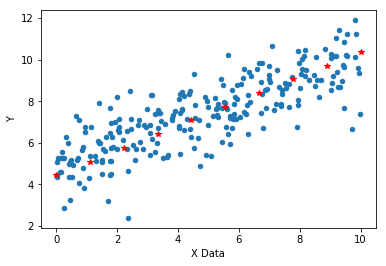

In [52]:
my_data.sample(n=250).plot(kind='scatter', x='X Data', y='Y')
plt.plot(brand_new_data, predictions, 'r*')